
# Topics
**Part I. The low level pipeline**
* Constructing the a mock TOD dataset
* Implement TOD filters (normalisation, polyfilter, PCA and down-sampling) and mapmaker
* Use implemented pipeline to filter the mock data

**Part II. The high level pipeline**
* Compute an auto and cross power spectrum, do you see any differences?
* A primer on CO models
* Perform an MCMC and grid search assuming you have a flat CO emission model
* Perform a two-parameter CO model MCMC and grid search
* Can we separate the two models? Which one fits best? 

# Special curriculum project

**Welcome to the COMAP-LIM special curriculum project notebook!** 

This project will cover aspects of the COMAP data and analysis pipeline. For the former we will go through a simplified simulated dataset and show how the data is created. For the latter your task is to implement some of the filters in the COMAP pipeline to clean the data and subsequently you will implement a simple binned mapmaker to recover the input signal. See *Foss et al. 2022* on how the filters and mapmaker work algorithmically. 

To summarize the information in the map we will thereafter consider the famous power spectrum where you will learn about and compute an auto-power spectrum and a cross-power spectrum. Details on how power spectra are estimated, both the auto and cross varieties, can be found in *Ihle et al. 2022*.   

Having a power spectrum in hand we of course want to get out some information from it about the actual underlying CO emission field. To investigate how this is done in practice we will consider a simple one-, and thereafter two-, parameter estimation using a gridding algorithm and Markov-Chain Monte Carlo (MCMC) technique. We will let you decide yourself whether to implement the MCMC yourself or use a package like `emcee` (available on e.g. pip), or both if you find that interesting (which we of course encourage if you have time :D). *In any case, it is still important that you can explain and draw how the implemented MCMC works even if you choose to use a stand-alone package.*

Lastly and most importantly, have fun and don't hesitate to ask if there is something you need help with :) 

To start of we import the needed Python packages

In [47]:
import numpy as np 
import h5py 
import matplotlib.pyplot as plt
import scipy.stats
import scipy
import astropy.units as u
from tqdm import trange
from dataclasses import dataclass


Next let's read the simulation cube from file. The simulations we use in COMAP are usually stored in the HDF5 formate, which we can open and load into `numpy`arrays using the `h5py`package as shown below. You can also open and look at the content of a HDF5 file using the terminal tool `h5ls`. 


But let's open and load a simulation and have a look at it. Note that the simulation in the file `../data/simulation/h5` is stored in $\mathrm{\mu K}$ and we therefore multiply by $10^6$ to obtain CO brightness temperatures in Kelvin. The simulation cube has three dimensions corresponding to the directions perpendicular to the line of sight of the telescope; Right Ascension (RA, x) and Declination (Dec, y) (these are the Equatorial coordinates), and the direction parallel to the line of sight corresponding to frequency or redshifted CO signal. Because the COMAP telescope chunks the measured frequency into four sidebands the frequency axis of the simulation cube is divided into two `numpy` axes (4, 128). As the simulations are made assuming the cube of simulations are situated at the celestial equator we must transform the pixel coordinates to the field center and transform the RA coordinate to physical degrees to account for a non-zero field declination.   

In [48]:
path = "../data/simulation/simcube.h5"

# Read simulation from file
with h5py.File(path, "r") as f:
    simcube = f["simulation"][()]
    x_bin_centers = f["x_bin_centers"][()]
    y_bin_centers = f["y_bin_centers"][()]
    x_bin_edges = f["x_bin_edges"][()]
    y_bin_edges = f["y_bin_edges"][()]

# Transfor to CO6 (Field 3) center
field_center = (226.0, 55.0)

# Define pixel resolutions
dra = np.diff(x_bin_centers)[0] / np.abs(np.cos(np.radians(field_center[1]))) # accounting for physical degrees at non-zero declination
ddec = np.diff(y_bin_centers)[0]

# Transform RA and Dec pixel centers and edges to Field 3 center and adjust RA to physical degrees
x_bin_centers = x_bin_centers / np.abs(np.cos(np.radians(field_center[1]))) + field_center[0]
y_bin_centers = y_bin_centers + field_center[1]
x_bin_edges = x_bin_edges  / np.abs(np.cos(np.radians(field_center[1])))  + field_center[0]
y_bin_edges = y_bin_edges + field_center[1]


Now that we have defined a mock of the sky patch we want to observe we need to simulate how the telescope observes the sky. We will do this by importing the pointing of the telescope from an actual observation.

Text(0, 0.5, 'Declination [deg]')

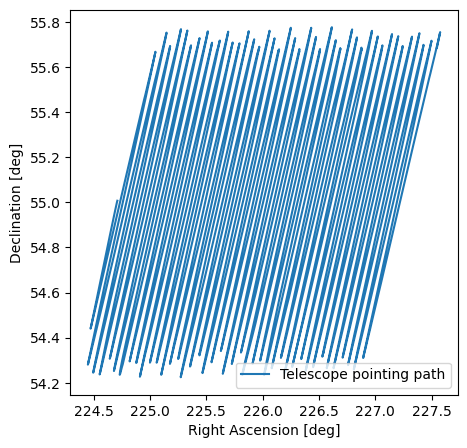

In [49]:
with h5py.File("../data/level2/scan_co6_001481703.h5", "r") as infile:
    ra = infile["ra"][()]  # Degrees
    dec = infile["dec"][()] # Degrees
    time = infile["time"][()] # sec
    freq = infile["frequency"][()] # GHz
    dt = time[1] - time[0]

# To plot the pointing we can do
fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(ra, dec, label = "Telescope pointing path")
ax.legend()
ax.set_xlabel("Right Ascension [deg]")
ax.set_ylabel("Declination [deg]")


Next, we can use the observation pointing `ra` and `dec` to define the pointing index and/or pointing matrix (see Foss et al. 2022 or Nils's MSc Thesis for illustration how these usually look). The pointing matrix/index are needed to simulate the telescope observation where we want to take a simulation map that we just read from file and generate a time-stream of observed signal (i.e. reverse map-making). But the pointing index is also needed later when your exercise it to implement a simple binned mapmaker. For simplicity we will use the same grid in the simulation and the later mapmaker task, but note that these could in general have been (and usually are) different. 

In [50]:
# Number of time samples in telescope observation
Ntime = ra.shape[-1]

# Number of RA and Dec pixels
Nx, Ny = x_bin_centers.size, y_bin_centers.size 

# Pointing index for a Plate-Carrée/Equirectangular projection
idx_ra = np.round((ra - x_bin_edges.min()) / dra).astype(np.int32)
idx_dec = np.round((dec - y_bin_edges.min()) / ddec).astype(np.int32)

# Remove any strange data samples that are outside of the defined map grid
idx_ra = idx_ra[~np.logical_or(idx_ra < 0, idx_ra >= Nx)]
idx_dec = idx_dec[~np.logical_or(idx_dec < 0, idx_dec >= Ny)]

# Pointing index for flattened map
pointing_idx = idx_dec * Nx + idx_ra

# Pointing matrix when filly represented
pointing_matrix = np.zeros((ra.shape[-1], Nx * Ny))
pointing_matrix[np.arange(Ntime), pointing_idx] = 1

To summarize what we have so far let us plot a frequency slice of the simulated CO mock sky and overplot the telescope pointing on top:

Text(0, 0.5, 'Declination [deg]')

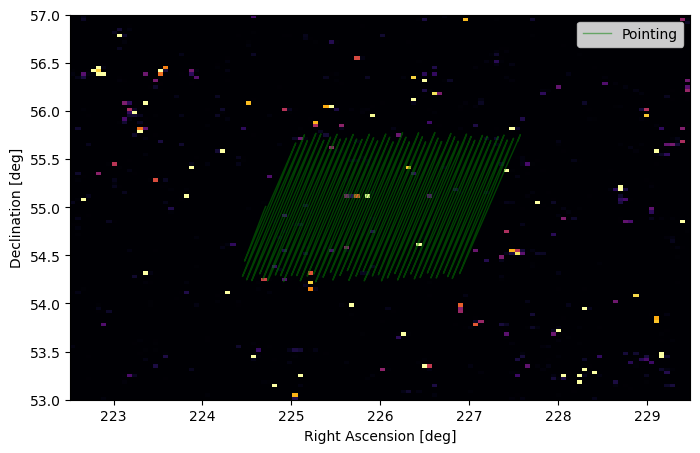

In [51]:
fig, ax = plt.subplots(figsize = (8, 5))

X, Y = np.meshgrid(x_bin_centers, y_bin_centers)
img = ax.pcolormesh(
    X,
    Y,
    simcube[0, 0, ...],
    cmap = "inferno",
    vmax = simcube[0, 0, ...].max() * 0.1
    
)

_ = ax.plot(ra, dec, lw = 1, alpha = 0.5, color = "g", label = "Pointing")

ax.set_xlim(x_bin_edges.min(), x_bin_edges.max())
ax.set_ylim(y_bin_edges.min(), y_bin_edges.max())

ax.legend()
ax.set_xlabel("Right Ascension [deg]")
ax.set_ylabel("Declination [deg]")



The signal that the telescope would observe from this can then be extracted from the cube by. Note that this in the actual COMAP pipeline is a bit more complicated and amongst other things uses some interpolation techniques to make the observed signal as smooth and realistic as possible. Here however, we are mostly just interested in the bird eye procedure and will skip the subtleties.

In [52]:
# Extract the signal time stream by use of our pointing index for RA and Dec
signal_tod = simcube[:, :, idx_ra, idx_dec]

# We now have 4*128 frequency observations for every time sample
signal_tod.shape

(4, 128, 20100)

Let's plot what we get from this at the first 1000 time samples at the first frequency:

Text(0, 0.5, 'Signal [$\\mu K$]')

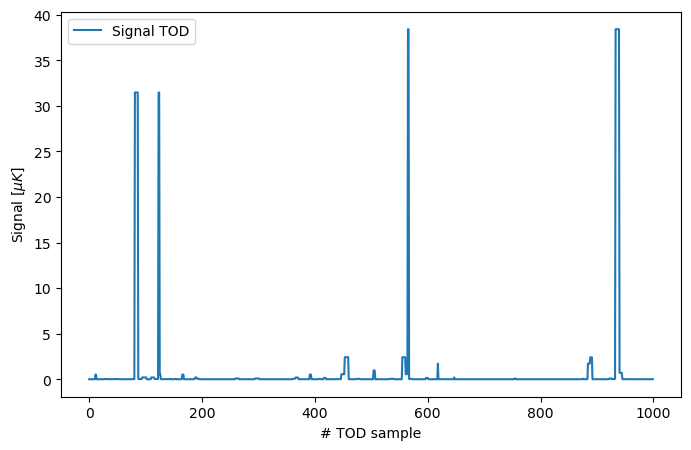

In [53]:
fig, ax = plt.subplots(figsize = (8, 5))

ax.plot(np.arange(Ntime)[:1000], signal_tod[0, 0, :1000], label = "Signal TOD")
ax.legend()
ax.set_xlabel(r"# TOD sample")
ax.set_ylabel(r"Signal [$\mu K$]")

(Note how "steppy" the signal looks because we do not use a proper interpolation scheme.)

Now, if the telescope would observe signal just like this, that would be wonderful (but not for us because we would lose our job having nothing to do :P ). However, in real life there are things like thermal electrons in the instrument, thermal emission from for instance the atmosphere as well as gain fluctuations from the telescope low-noise amplifiers LNA. 

There are typically two types of noise in a radio telescope: White noise $n_0$, and $1/f$ noise $n_{1/f}$. White noise is simply, uncorrelated noise, which arises from anything from the temperature of the atmosphere to the temperature of the detectors. $1/f$ noise is a specific (but important) type of noise created from the low noise amplifiers (LNAs) within the telescope electronics. These are heavily correlated on longer timescales, and their power spectrum is inversely proportional to the frequency, aka a $1/f$ shape. We typically write the combined noise as
$$\mathrm{PSD}_\mathrm{1/f} = \sigma_0^2 \left(1 + \left(\frac{|f|}{f_\mathrm{knee}}\right)^\alpha\right) = \underbrace{\sigma_0^2}_{n_0} + \underbrace{\sigma_0^2\left(\frac{|f|}{f_\mathrm{knee}}\right)^\alpha}_{n_{1/f}},$$
which depends on three parameters.

1. The white noise level $\sigma_0$ that descibes the standard-deviation of the Gaussian from which the Gaussian random white noise in the data is drawn from; $\mathcal{N}(0, \sigma_0)$.
2. The knee frequency $f_\mathrm{knee}$ where the correlated $1/f$ noise component and the white noise become roughly equal.
3. The slope $\alpha$ of the $1/f$ noise component. 

Let's define a function that generated the $1/f$ component PSD:

In [54]:
def one_over_f(f, sigma0, fknee, alpha):
    """Power spectral density model of 1/f correlated noise

    Args:
        f: frequency
        sigma0: White noise level
        fknee: Knee frequency of 1/f
        alpha: Slope of 1/f

    """
    return sigma0 ** 2 * (np.abs(f) / fknee) ** alpha

To get some instrumental white noise we use our good old friend `numpy`.

In [55]:
sigma0, fknee, alpha = 59.5, 0.6, -1.8

white_noise = sigma0 * np.random.normal(0, 1, signal_tod.shape)

Feel free to play around with the noise-level in the data. When doing so, it's best to adjust sigma0, and leave the others alone. You can, for example, set sigma0 to a very small number, so that the data contains only the CO, which can be useful for debuging.

**Task:** Why do we multiply $\sigma_0$ by a number $n\sim \mathcal{N}(0, 1)$? How does this relate to a number $n\sim\mathcal{N}(0, \sigma_0)$?

To get the correlated noise component we must first compute the $1/f$ PSD using some predefined noise parameters. Thereafter we generate a set of white noise similar to the one in the cell above. To convert the white noise to correlated noise we transform it into Fourier space and multiply by the $1/f$ spectrum before transforming back to real space.

In [56]:
def get_noise(sigma0, fknee, alpha, seed = 42):
    # Some random seed
    np.random.seed(seed)

    # Frequencies given the sample time dt of the telescope (20 ms)
    f = np.fft.fftfreq(Ntime, dt)

    # Some realistic noise parameters

    # Generate the 1/f spectrum
    psd_corr = one_over_f(f, sigma0, fknee, alpha)
    psd_corr[f == 0] = 0 # Removing the singular frequency

    # Generate 1/f correlated noise from generated white noise array 
    correlated_noise = np.random.normal(0, 1, signal_tod.shape[2])
    fft_noise = np.fft.fft(correlated_noise, axis = -1)

    # Inverse transform to get the correlated noise
    correlated_noise = np.fft.ifft(np.sqrt(psd_corr) * fft_noise, axis = -1).real

    white_noise = sigma0 * np.random.normal(0, 1, signal_tod.shape)
    
    return correlated_noise, white_noise, fft_noise, psd_corr, f

correlated_noise, white_noise, fft_noise, psd_corr, f = get_noise(sigma0, fknee, alpha, seed = 42) 

/var/folders/gf/7myrg_894l96llyf6x7lqj0h0000gp/T/ipykernel_62614/3092544724.py:11: RuntimeWarning: divide by zero encountered in power
  return sigma0 ** 2 * (np.abs(f) / fknee) ** alpha


We can then plot the noise data in both Fourier space (PSDs) and real space to see how they look (*do you see why it is called correlated noise and white noise?*):

Text(0.5, 0, '# time sample')

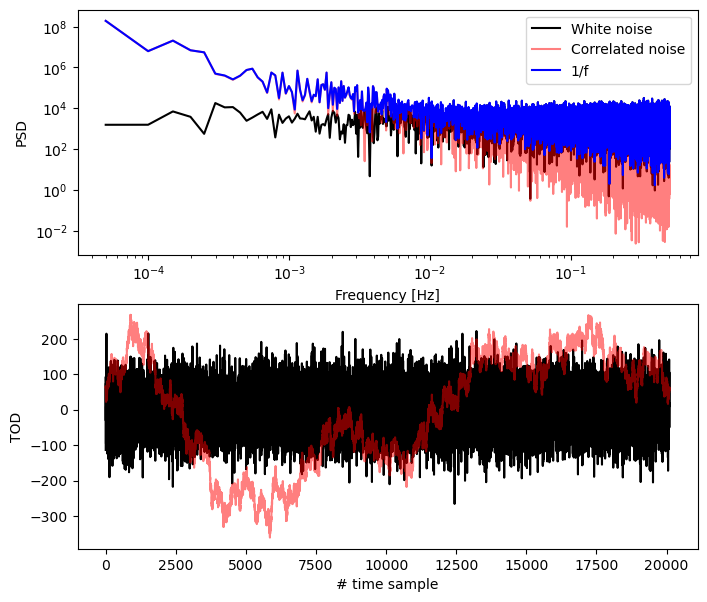

In [57]:
def calculate_PS(data):
    return np.abs(np.fft.rfft(data)**2)[1:]/data.shape[-1]
fft_freq = np.fft.rfftfreq(white_noise.shape[-1])[1:]
fig, ax = plt.subplots(2, 1, figsize = (8, 7))
ax[0].plot(fft_freq, calculate_PS(white_noise[0,0]), alpha = 1, label = "White noise", color = "k")
ax[0].plot(fft_freq, calculate_PS(correlated_noise), label = "Correlated noise", alpha = 0.5, color = "red")
ax[0].plot(fft_freq, calculate_PS(correlated_noise) + calculate_PS(white_noise[0,0]), label = "1/f", color = "blue")
ax[0].legend()
ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_ylabel("PSD")
ax[0].set_xlabel("Frequency [Hz]")

ax[1].plot(np.arange(Ntime), white_noise[0, 0, :], alpha = 1, label = "White noise", color = "k")
ax[1].plot(np.arange(Ntime), correlated_noise, label = "Correlated noise", alpha = 0.5, color = "red")
ax[1].set_ylabel("TOD")
ax[1].set_xlabel("# time sample")



The total noise then becomes the sum of the white and correlated noise:

In [58]:
noise = correlated_noise[None, None, :] + white_noise  

Note that the COMAP instrument has independent and unique white noise for all frequency and time samples, but the correlated noise is the same for all frequencies (up to an offset). This is one of the powerful properties that makes us able to filter it out again as we will see later.

Finally, we can stitch the two parts of the observation by adding the signal and the noise together. We will also allow for a boost of the signal to make it detectable over the noise, and you can play around with it a bit later to see what effect it has on the results. We also subtract the mean signal from the box because the COMAP pipeline cannot actually measure average signal (sometimes called Field monopole). 

In [59]:
signal = signal_tod - simcube.mean()
data = noise + signal

Let us plot what we have created:

Text(0.5, 0, '# time sample')

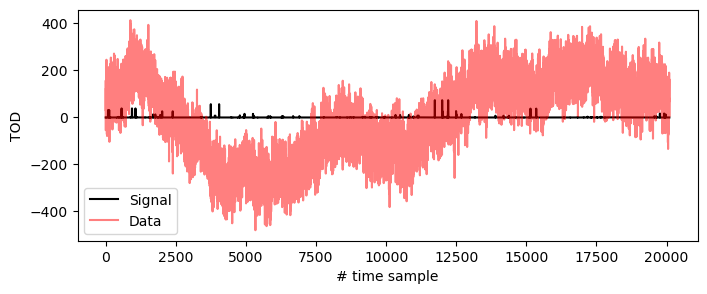

In [60]:
fig, ax = plt.subplots(figsize = (8, 3))

ax.plot(np.arange(Ntime), signal[0, 0, :], label = "Signal", alpha = 1, color = "k")
ax.plot(np.arange(Ntime), data[0, 0, :], label = "Data", alpha = 0.5, color = "red")
ax.legend()
ax.set_ylabel("TOD")
ax.set_xlabel("# time sample")


Or in a 2D waterfall plot:

Text(0.5, 0, '# Time sample')

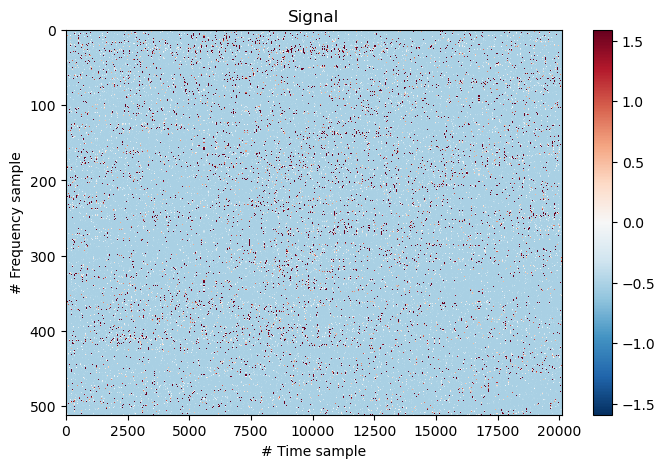

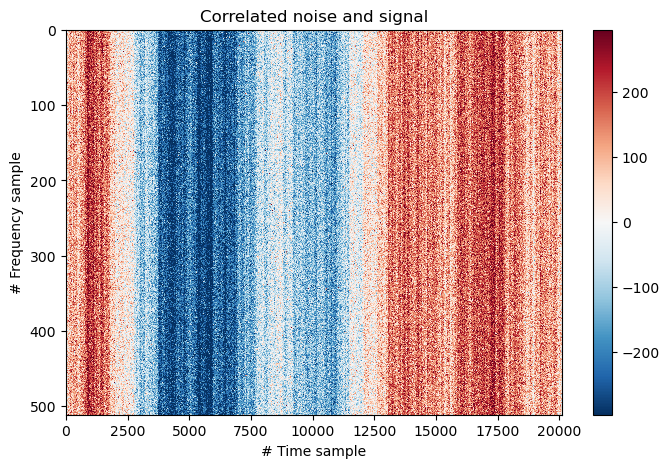

In [61]:

fig, ax = plt.subplots(figsize = (8, 5))
ax.set_title("Signal")

img = ax.imshow(
    (signal).reshape(4 * 128, Ntime),
    cmap = "RdBu_r",
    interpolation = "none",
    aspect = "auto",
    vmin = -np.percentile(np.abs(signal.flatten()), 98),
    vmax = np.percentile(np.abs(signal.flatten()), 98),
)
plt.colorbar(img, ax=ax)
ax.set_ylabel("# Frequency sample")
ax.set_xlabel("# Time sample")

fig, ax = plt.subplots(figsize = (8, 5))
ax.set_title("Correlated noise and signal")

img = ax.imshow(
    (data).reshape(4 * 128, Ntime),
    cmap = "RdBu_r",
    interpolation = "none",
    aspect = "auto",
    vmin = -np.percentile(np.abs(data.flatten()), 95),
    vmax = np.percentile(np.abs(data.flatten()), 95),
)
plt.colorbar(img, ax=ax)
ax.set_ylabel("# Frequency sample")
ax.set_xlabel("# Time sample")

### Time to analyse some data (here the fun begins :D)...

**Task:** Implement the Poly-filter, which subtracts a first order polynomial across frequency from each time-step. The function should take the TOD and the TOD uncertainty, and return a new TOD with filtered data.

**Task:** Implement a down-sampling scheme, where the 512 frequency channels are reduced by a factor of 4, to 128. The function should take the full TOD and the TOD uncertainty, and return the downsampled TOD, together with the downsampled TOD uncertainty. Be careful that you get the uncertainty right, it is not added together the same way as the signal!

**Task:** Implement a simple inverse-variance binned mapmaker. The function should take the downsampled TOD, and the TOD uncertainty, as input, and return three maps: The signal map, the uncertainty map, and the hit-count map.

In each of the three points make sure you understand how each filter works and what it does to the data. Plot the data between each step to see what happens to it.

In [62]:
# Fill in all functions that return 'NotImplemented'

def polyfilter(tod, sigma):
    return NotImplemented

def downsampler(data, sigma):
    return NotImplemented

def mapmaker(tod, sigma):
    return NotImplemented

**Task:** If you turn down the noise level, such that the signal dominates, you will see stripes in the data (along the frequency axis) after performing the poly-filter. This is a common phenomenon in astrophysical data processing and mapmaking when fitting some function to data with point sources. It is often referred to as "ringing". Try and understand why this happens. Why is it not visible when the noise is higher?

**Task:** Compute an auto power spectrum of the map you just created. See Ihle et al. 2022 and/or Nils' MSc Thesis for expression. 

In [68]:
# Translation factors from observational units to Mpc
angle2Mpc = (3.63 * u.Mpc) / (2 * u.arcmin)  
MHz2Mpc = (4.26 * u.Mpc) / (32 * u.MHz)  

# Map resolution in cosmological units; Mpc
dx = ((dra * u.deg) * angle2Mpc).to(u.Mpc) * np.abs(np.cos(np.radians(field_center[1]))) # accounting for physical degrees at non-zero declination
dy = ((ddec * u.deg) * angle2Mpc).to(u.Mpc)
dz = (np.diff(freq.flatten())[0] * u.GHz * MHz2Mpc).to(u.Mpc)
print(dx, dy, dz)

# We don't need the astropy unit anymore from here
dx, dy, dz = dx.value, dy.value, dz.value

kbin_edges = np.logspace(-1, 0, 11)

weight = 1 / sigmamap ** 2
weight = np.sqrt(weight * weight) / np.sqrt(np.nanmean((weight * weight)))



tod_downsampled_signal, sigma_downsampled_signal = downsampler(signal.copy(), sigma, 4)

_, datamap_signal, _ = mapmaker(tod_downsampled_signal, sigma_downsampled_signal, pointing_idx)



# TODO
def get_auto_power_spectrum(datamap, weight, dx, dy, dz, kbin_edges):
    return NotImplemented

3.630000000000036 Mpc 3.630000000000036 Mpc 2.0800781249999996 Mpc


/var/folders/gf/7myrg_894l96llyf6x7lqj0h0000gp/T/ipykernel_62614/95788510.py:57: RuntimeWarning: invalid value encountered in divide
  data_map = datasum / varsum
/var/folders/gf/7myrg_894l96llyf6x7lqj0h0000gp/T/ipykernel_62614/95788510.py:58: RuntimeWarning: divide by zero encountered in divide
  sigma_map = np.sqrt(1 / varsum)


**Task:** Compute a cross power spectrum of the maps you just created. Note that because a cross-spectrum requires two different maps you need to create another map, just like the first you made, with the same signal but a different noise seed. What differences do you see between the auto- and cross-power spectra?

In [71]:
# Let's make another map with independent noise
correlated_noise_2, white_noise_2, _, _, _ = get_noise(sigma0, fknee, alpha, seed = 7652) 
noise_2 = correlated_noise_2[None, None, :] + white_noise_2  

data_2 = noise_2 + signal

sigma_2 = np.std((data_2[..., 1:] - data_2[..., :-1]) / 2, axis = 2)

tod_polyfiltered_2 = polyfilter(data_2.copy(), sigma_2)

tod_downsampled_2, sigma_downsampled_2 = downsampler(tod_polyfiltered_2.copy(), sigma_2, 4)

hitmap_2, datamap_2, sigmamap_2 = mapmaker(tod_downsampled_2, sigma_downsampled_2, pointing_idx)

weight_cross = 1 / sigmamap ** 2 * 1 / sigmamap_2 ** 2
weight_cross = np.sqrt(weight_cross) / np.sqrt(np.nanmean(weight_cross))


/var/folders/gf/7myrg_894l96llyf6x7lqj0h0000gp/T/ipykernel_62614/3092544724.py:11: RuntimeWarning: divide by zero encountered in power
  return sigma0 ** 2 * (np.abs(f) / fknee) ** alpha
/var/folders/gf/7myrg_894l96llyf6x7lqj0h0000gp/T/ipykernel_62614/95788510.py:57: RuntimeWarning: invalid value encountered in divide
  data_map = datasum / varsum
/var/folders/gf/7myrg_894l96llyf6x7lqj0h0000gp/T/ipykernel_62614/95788510.py:58: RuntimeWarning: divide by zero encountered in divide
  sigma_map = np.sqrt(1 / varsum)


In [72]:
def get_cross_power_spectrum(datamap1, datamap2, w, dx, dy, dz, kbin_edges):
    return NotImplemented

In [75]:
np.save("../data/PS_cross.npy", cross_spectrum)
np.save("../data/PS_signal.npy", auto_power_spectrum_signal)
np.save("../data/k.npy", k)

## Optional task: Estimating the power spectrum uncertainty (do this after part 2).
You have already calculated the uncertainty of each map-pixel, which was relatively straight-forward, as long as the uncertainty of the TOD is known. Estimating the uncertainty in each power spectrum bin is not as straight-forward. The easiest way of doing this is to simulate the uncertainty by creating a lot of simulated maps, calculating the power spectra of those maps, and seeing how much they wary.
- From the pixel uncertainty maps, `sigmamap`, create two random noise maps, using `np.random.normal`.
- Calculate the cross power spectrum from these two noise maps, just like you did for the "real" maps, `datamap` and `datamap_2`.
- Repeat the two above steps maybe 100 times, and put the individual cross power spectra in a list or array.
- Calculate the standard deviation across the 100 power spectrum simuations. This is a good estimate of the power spectrum uncertainty!

**This is the end of project part 1. For part 2 on MCMC see `spesialpensum_project_part2.ipynb` notebook.**